## Self driving car model

In [1]:
!git clone https://github.com/tzudir/Self_driving

Cloning into 'Self_driving'...
remote: Enumerating objects: 138281, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 138281 (delta 1), reused 1 (delta 0), pack-reused 138276
Receiving objects: 100% (138281/138281), 1.45 GiB | 14.42 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Updating files: 100% (112595/112595), done.


In [3]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as keras
import tensorflow as tf
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Lambda, BatchNormalization
from keras.optimizers import Adam
from keras.optimizers import schedules
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath

In [21]:
datadir = '/content/Self_driving/drive2'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)

In [22]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,Desktop\track2data\IMG\center_2019_04_02_18_05_37_641.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_641.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_641.jpg,0.0,0.0,0.0,0.000275
1,Desktop\track2data\IMG\center_2019_04_02_18_05_37_712.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_712.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_712.jpg,0.0,0.0,0.0,0.000280
2,Desktop\track2data\IMG\center_2019_04_02_18_05_37_783.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_783.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_783.jpg,0.0,0.0,0.0,0.000277
3,Desktop\track2data\IMG\center_2019_04_02_18_05_37_853.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_853.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_853.jpg,0.0,0.0,0.0,0.000046
4,Desktop\track2data\IMG\center_2019_04_02_18_05_37_922.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_922.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_922.jpg,0.0,0.0,0.0,0.000060


In [23]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [24]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_04_02_18_05_37_641.jpg,left_2019_04_02_18_05_37_641.jpg,right_2019_04_02_18_05_37_641.jpg,0.0,0.0,0.0,0.000275
1,center_2019_04_02_18_05_37_712.jpg,left_2019_04_02_18_05_37_712.jpg,right_2019_04_02_18_05_37_712.jpg,0.0,0.0,0.0,0.000280
2,center_2019_04_02_18_05_37_783.jpg,left_2019_04_02_18_05_37_783.jpg,right_2019_04_02_18_05_37_783.jpg,0.0,0.0,0.0,0.000277
3,center_2019_04_02_18_05_37_853.jpg,left_2019_04_02_18_05_37_853.jpg,right_2019_04_02_18_05_37_853.jpg,0.0,0.0,0.0,0.000046
4,center_2019_04_02_18_05_37_922.jpg,left_2019_04_02_18_05_37_922.jpg,right_2019_04_02_18_05_37_922.jpg,0.0,0.0,0.0,0.000060


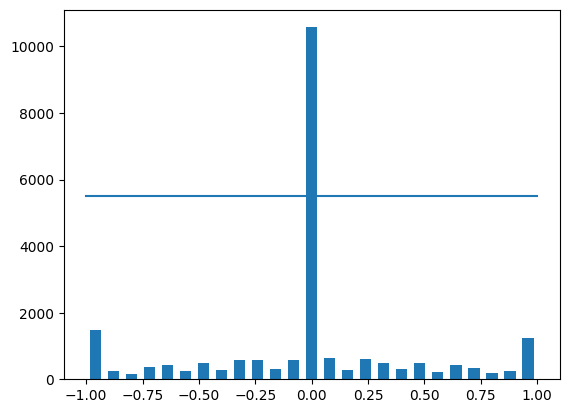

In [25]:
num_bins = 25
samples_per_bin = 5500
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [26]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

removed:  5075
remaining:  16753


In [27]:
hist, bins = np.histogram(data['steering'], (num_bins))

In [28]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [29]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [30]:
image_paths

array(['/content/Self_driving/drive2/IMG/center_2019_04_02_18_05_37_783.jpg',
       '/content/Self_driving/drive2/IMG/left_2019_04_02_18_05_37_783.jpg',
       '/content/Self_driving/drive2/IMG/right_2019_04_02_18_05_37_783.jpg',
       ...,
       '/content/Self_driving/drive2/IMG/center_2019_04_02_18_31_04_870.jpg',
       '/content/Self_driving/drive2/IMG/left_2019_04_02_18_31_04_870.jpg',
       '/content/Self_driving/drive2/IMG/right_2019_04_02_18_31_04_870.jpg'],
      dtype='<U67')

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 40207
Valid Samples: 10052


Text(0.5, 1.0, 'Validation set')

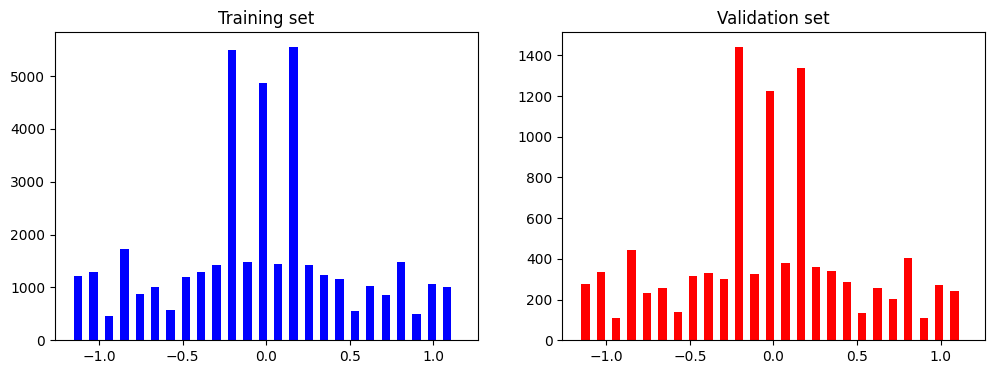

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [33]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


In [34]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [35]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [36]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
# def nvidia_model():
#   model = Sequential()
#   model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
#   model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
#   model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
#   model.add(Conv2D(64, (5, 5), activation='elu'))


#   model.add(Flatten())

#   model.add(Dense(100, activation = 'elu'))

#   model.add(Dense(50, activation = 'elu'))

#   model.add(Dense(10, activation = 'elu'))


#   model.add(Dense(1))

#   optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
#   model.compile(loss='mse', optimizer=optimizer)
#   return model

# model = nvidia_model()
# print(model.summary())

In [40]:
def get_model():
    model = Sequential([
        Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=(66, 200, 3)),
        BatchNormalization(axis=1),
        Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        BatchNormalization(axis=1),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])

    return model

model = get_model()
initial_learning_rate = 0.001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 batch_normalization_16 (Ba  (None, 31, 98, 24)        124       
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 batch_normalization_17 (Ba  (None, 14, 47, 36)        56        
 tchNormalization)                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 batch_normalization_18 (Ba  (None, 5, 22, 48)        

In [41]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=20,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

<ipython-input-41-7404206d07fa>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/20
300/300 [==============================] - 142s 459ms/step - loss: 0.3391 - val_loss: 0.2294
Epoch 2/20
300/300 [==============================] - 136s 456ms/step - loss: 0.2353 - val_loss: 0.2049
Epoch 3/20
300/300 [==============================] - 136s 456ms/step - loss: 0.2282 - val_loss: 0.1944
Epoch 4/20
300/300 [==============================] - 134s 447ms/step - loss: 0.2240 - val_loss: 0.1950
Epoch 5/20
300/300 [==============================] - 122s 408ms/step - loss: 0.2146 - val_loss: 0.1841
Epoch 6/20
300/300 [==============================] - 134s 446ms/step - loss: 0.2114 - val_loss: 0.1893
Epoch 7/20
300/300 [==============================] - 121s 406ms/step - loss: 0.2116 - val_loss: 0.1934
Epoch 8/20
300/300 [==============================] - 121s 404ms/step - loss: 0.2089 - val_loss: 0.1851
Epoch 9/20
300/300 [==============================] - 135s 452ms/step - loss: 0.2064 - val_loss: 0.1893
Epoch 10/20
300/300 [==============================] - 121s 404m

Text(0.5, 0, 'Epoch')

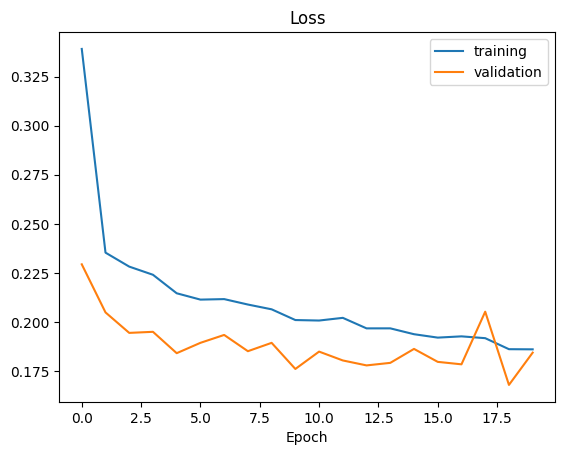

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [43]:
model.save('model9.h5')
from google.colab import files
files.download('model9.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

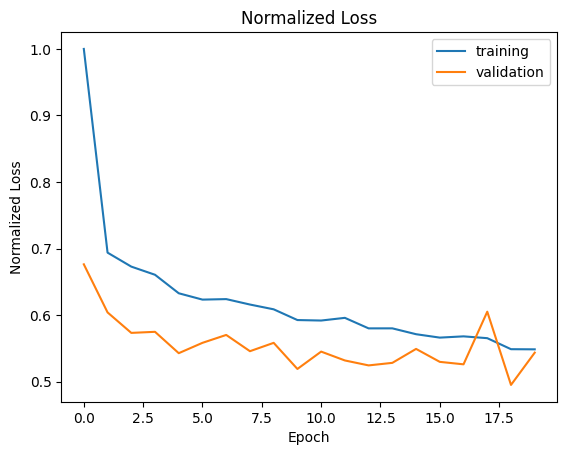

In [44]:
# Assuming history.history['loss'] and history.history['val_loss'] contain the loss values
# Normalize the loss values
max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
normalized_loss = [loss / max_loss for loss in history.history['loss']]
normalized_val_loss = [val_loss / max_loss for val_loss in history.history['val_loss']]

plt.plot(normalized_loss)
plt.plot(normalized_val_loss)
plt.legend(['training', 'validation'])
plt.title('Normalized Loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.show()
